## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

X is 3564
The acquisition, up to row 100000 lasted 88570163.33333333 ns
Most noisy channels are 
              counting
TDC_CHANNEL          
63               4917
64               5027
139              8320


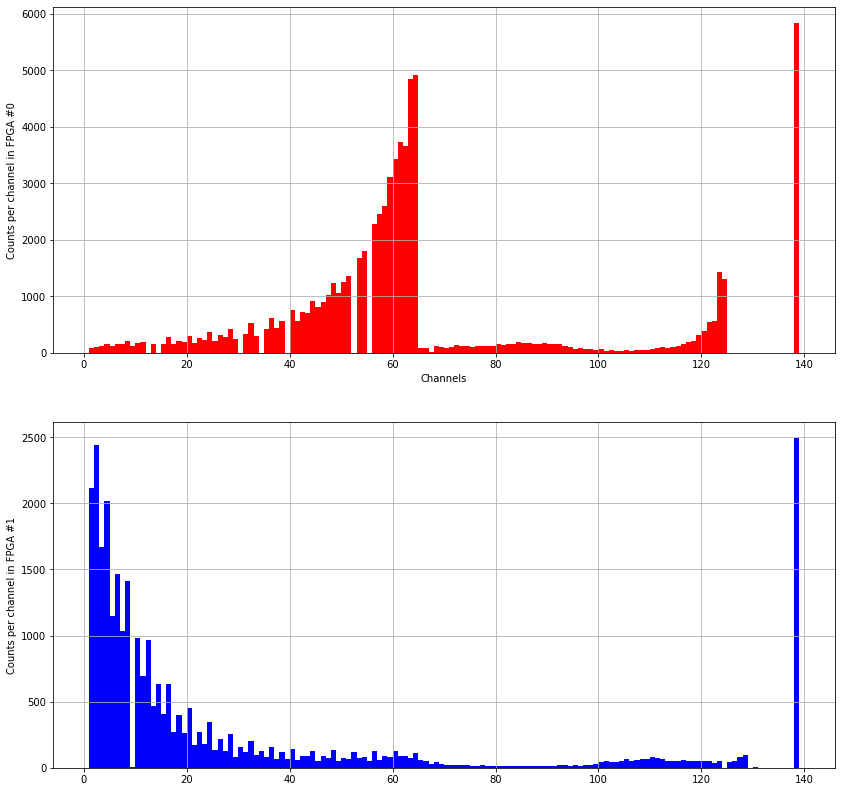

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#bigger plots
plt.rcParams['figure.figsize'] = [14, 14]

#1)
#Nrows=int(input("How many rows should I read? "))
Nrows=100000
file_name="~/data/data_000637.txt"
data=pd.read_csv(file_name,nrows=Nrows)

#2)finding x
x=data["BX_COUNTER"].max()+1
print("X is",x)
#the plus one is because, if an hour has 60 minutes, the max minutes I can see is 59, not 60

#3)data taking time
Bxcounts=(data["ORBIT_CNT"][Nrows-1]-data["ORBIT_CNT"][0])*x+(data["BX_COUNTER"][Nrows-1]-data["BX_COUNTER"][0])
time=25*Bxcounts+(data["TDC_MEAS"][Nrows-1]-data["TDC_MEAS"][0])*(25/30)#in ns
print("The acquisition, up to row",Nrows,"lasted",time,"ns")

#4)column with time in ns
data['timens']=data['TDC_MEAS']*25/30+(data['BX_COUNTER']+data["ORBIT_CNT"]*x)*25
#data

#5)random head
data["HEAD"]=np.random.randint(0,2,size=(Nrows))

#6)new dataframe with HEAD=1
newdata=data[data["HEAD"]>0]

#7)histo of TDC channels
plt.subplot(2,1,1)
plot1=data[data["FPGA"]==0]["TDC_CHANNEL"].hist(bins=range(min(data["TDC_CHANNEL"]), max(data["TDC_CHANNEL"]) + 1, 1),color='r')
plt.xlabel("Channels")
plt.ylabel("Counts per channel in FPGA #0")
plt.subplot(2,1,2)
plot2=data[data["FPGA"]==1]["TDC_CHANNEL"].hist(bins=range(min(data["TDC_CHANNEL"]), max(data["TDC_CHANNEL"]) + 1, 1),color='b')
plt.ylabel("Counts per channel in FPGA #1")

#8)channels with most counts (considering FPGA 0 and 1 together)
data['counting'] = np.array([1] * (Nrows))#if HEAD would still be all 1, no need for new column!
dc=data.groupby("TDC_CHANNEL").sum()
d=dc.sort_values(by="counting")
#to see more channels, just change 3 with desired number; all columns except "counting" are just unphysical
#so we will drop them
final=d.drop(columns=['HEAD',"FPGA",'BX_COUNTER',"ORBIT_CNT","TDC_MEAS","timens"])
print("Most noisy channels are",'\n',final.tail(3))

#9)orbits counting
Allorbits=np.unique(data["ORBIT_CNT"].to_numpy())
OrbitsCH139=np.unique(data[data["TDC_CHANNEL"]==139]["ORBIT_CNT"].to_numpy())
#print(len(Allorbits)
#print(len(OrbitsCH139)